# EEG States
Training a model on manually labelled EEG data to find various states.

In [2]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter
log = lambda msg: logging.info(msg)


# Load data

In [3]:
input_dir = "C:\\dev\\play\\brainwave-data"
stats_df = pd.read_csv(input_dir + os.path.sep + "stats.csv")


In [4]:
from models.eeg_states.eeg_states import load_and_prepare_generic_eeg_state_events

events = load_and_prepare_generic_eeg_state_events()

C:\dev\play\brainwave-processor\models\eeg_states\eeg_states.py:97: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-10-09 20:17:27.992000+00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  events.at[i, 'since'] = since_time
C:\dev\play\brainwave-processor\models\eeg_states\eeg_states.py:99: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  events['duration'] = events['timestamp'] - events['since']


In [5]:
events

,timestamp,event,since,duration,TimestampUK,SinceUK,dayAndNightOf
0,2024-10-09 20:22:27.992000+00:00,tired_long,2024-10-09 20:17:27.992000+00:00,0 days 00:05:00,2024-10-09 21:22:27.992000+01:00,2024-10-09 21:17:27.992000+01:00,2024-10-09
1,2024-10-09 20:28:57.046000+00:00,tired,NaT,NaT,2024-10-09 21:28:57.046000+01:00,NaT,2024-10-09
2,2024-10-09 20:32:36.824000+00:00,tired,NaT,NaT,2024-10-09 21:32:36.824000+01:00,NaT,2024-10-09
3,2024-10-09 20:32:52.775000+00:00,tired_long,2024-10-09 20:32:36.824000+00:00,0 days 00:00:15.951000,2024-10-09 21:32:52.775000+01:00,2024-10-09 21:32:36.824000+01:00,2024-10-09
4,2024-10-09 20:33:13.921000+00:00,tired,NaT,NaT,2024-10-09 21:33:13.921000+01:00,NaT,2024-10-09
...,...,...,...,...,...,...,...
283,2024-11-13 23:14:16.537000+00:00,tired,NaT,NaT,2024-11-13 23:14:16.537000+00:00,NaT,2024-11-13
284,2024-11-13 23:19:46.216000+00:00,tired_long,2024-11-13 23:14:46.216000+00:00,0 days 00:05:00,2024-11-13 23:19:46.216000+00:00,2024-11-13 23:14:46.216000+00:00,2024-11-13
285,2024-11-13 23:24:16.899000+00:00,tired_long,2024-11-13 23:19:46.216000+00:00,0 days 00:04:30.683000,2024-11-13 23:24:16.899000+00:00,2024-11-13 23:19:46.216000+00:00,2024-11-13
286,2024-11-13 23:31:04.370000+00:00,tired,NaT,NaT,2024-11-13 23:31:04.370000+00:00,NaT,2024-11-13


In [6]:
events['event'].value_counts()

event
tired         145
tired_long     95
wired          24
wired_long     24
Name: count, dtype: int64

In [7]:
just_types = events['event'].unique()
just_types = [col for col in just_types if not "long" in col]
just_types


['tired', 'wired']

## Load other data

In [8]:
import os

dfs = []

for root, dirs, files in os.walk(input_dir):
    for idx, dir_name in enumerate(dirs):
        input_file = os.path.join(root, dir_name, "raw.post_human.csv")
        if os.path.exists(input_file):
            df = pd.read_csv(input_file)
            dfs.append(df)

yasa_df = pd.concat(dfs, ignore_index=True)

In [9]:
yasa_df_orig = yasa_df.copy()
assert yasa_df.index.is_unique, "Index is not unique"

In [10]:
yasa_df.shape

(66508, 1625)

In [11]:
yasa_df['dayAndNightOf'].value_counts()

dayAndNightOf
2024-09-24    2083
2024-08-19    1848
2024-09-03    1780
2024-08-20    1502
2024-10-11    1389
              ... 
2024-09-16     314
2024-07-08     310
2024-10-29     135
2024-11-03     105
2024-10-20      83
Name: count, Length: 62, dtype: int64

# Prepare data - find if in state

In [12]:
from sleep_events import convert_timestamps_to_uk

convert_timestamps_to_uk(yasa_df, 'Timestamp', 'TimestampUK')

In [13]:
yasa_df['TimestampUK']

0       2024-07-08 22:51:16.763590097+01:00
1       2024-07-08 22:51:46.763590097+01:00
2       2024-07-08 22:52:16.763590097+01:00
3       2024-07-08 22:52:46.763590097+01:00
4       2024-07-08 22:53:16.763590097+01:00
                        ...                
66503   2024-11-08 07:46:18.485414982+00:00
66504   2024-11-08 07:46:48.485414982+00:00
66505   2024-11-08 07:47:18.485414982+00:00
66506   2024-11-08 07:47:48.485414982+00:00
66507   2024-11-08 07:48:18.485414982+00:00
Name: TimestampUK, Length: 66508, dtype: datetime64[ns, Europe/London]

In [14]:
from models.eeg_states.eeg_states import process_row, process_row_for_pulearn
import pandas as pd
from tqdm import tqdm

# Pre-filter the data as it takes ages
first_timestamp_uk = events['TimestampUK'].min()
filtered_yasa_df = yasa_df[yasa_df['TimestampUK'] >= first_timestamp_uk]

# Add new columns to yasa_df to store the epoch type
yasa_df = filtered_yasa_df.copy()  # defragment
for event_type in just_types:
    yasa_df[event_type] = 0

# Iterate over each row in yasa_df
for i, yasa_row in tqdm(yasa_df.iterrows(), total=yasa_df.shape[0]):
    matched_events = process_row_for_pulearn(yasa_row, events, just_types)
    for event_type, value in matched_events.items():
        yasa_df.at[i, event_type] = value

100%|██████████| 13940/13940 [03:23<00:00, 68.41it/s] 


In [15]:
for type in just_types:
    print(yasa_df[type].value_counts())

tired
0    13824
1      116
Name: count, dtype: int64
wired
0    13918
1       22
Name: count, dtype: int64


In [16]:
from memory import garbage_collect

garbage_collect(log)

In [17]:
from models.eeg_states.eeg_states_model import generic_state_model_pipeline

models_and_data = []

for event_type in just_types:
    models_and_data.append(generic_state_model_pipeline(event_type + ' realtime', yasa_df, event_type, True))


['Main_eeg_abspow_s', 'Main_eeg_alpha_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaab_s', 'Main_eeg_alphaabs_s', 'Main_eeg_alphaabsaa_s', 'Main_eeg_alphaabsab_s', 'Main_eeg_at_s', 'Main_eeg_auc_s', 'Main_eeg_beta_s', 'Main_eeg_betaabs_s', 'Main_eeg_db_s', 'Main_eeg_ds_s', 'Main_eeg_dt_s', 'Main_eeg_fdelta_s', 'Main_eeg_fdeltaaa_s', 'Main_eeg_fdeltaab_s', 'Main_eeg_fdeltaabs_s', 'Main_eeg_fdeltaabsaa_s', 'Main_eeg_fdeltaabsab_s', 'Main_eeg_hcomp_s', 'Main_eeg_higuchi_s', 'Main_eeg_hmob_s', 'Main_eeg_iqr_s', 'Main_eeg_kurt_s', 'Main_eeg_nzc_s', 'Main_eeg_perm_s', 'Main_eeg_perment_s', 'Main_eeg_petrosian_s', 'Main_eeg_sdelta_s', 'Main_eeg_sdeltaabs_s', 'Main_eeg_sigma_s', 'Main_eeg_sigmaaa_s', 'Main_eeg_sigmaab_s', 'Main_eeg_sigmaabs_s', 'Main_eeg_sigmaabsaa_s', 'Main_eeg_sigmaabsab_s', 'Main_eeg_skew_s', 'Main_eeg_specent_s', 'Main_eeg_spectral_centroid_s', 'Main_eeg_std_s', 'Main_eeg_svdent_s', 'Main_eeg_theta_s', 'Main_eeg_thetaaa_s', 'Main_eeg_thetaab_s', 'Main_eeg_thetaabs_s', 'Main_eeg

In [18]:
from models.eeg_states.eeg_states_model import ModelAndData
from sklearn.model_selection import train_test_split

def split(modelAndData: ModelAndData):
    X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.2, random_state=42)
    modelAndData.X_train = X_train_to_sleep
    modelAndData.y_train = y_train_to_sleep
    modelAndData.X_val = X_val_to_sleep
    modelAndData.y_val = y_val_to_sleep

for md in models_and_data:
    split(md)
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

Training set size tired realtime: 11152, validation set size: 2788
Training set size wired realtime: 11152, validation set size: 2788


# Train pulearn models

In [34]:
from pulearn import ElkanotoPuClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


def train(md: ModelAndData):
    #svc = SVC(C=10, kernel='rbf', gamma=0.4, probability=True)
    estimator = XGBClassifier(eval_metric='logloss',
                              n_estimators=1000,
                              max_depth=6)
    pu_estimator = ElkanotoPuClassifier(estimator=estimator, hold_out_ratio=0.1)
    log(f"Training model for {md.name}")
    print(f"X_train shape: {md.X_train.shape}")
    print(f"y_train shape: {md.y_train.shape}")
    # X_train = md.X_train.reset_index(drop=True)
    # y_train = md.y_train.reset_index(drop=True)
    # binary_array = np.random.randint(2, size=md.y_train.shape)

    md.model = pu_estimator.fit(md.X_train.to_numpy(), md.y_train.to_numpy())

for md in models_and_data:
    train(md)

X_train shape: (11152, 48)
y_train shape: (11152,)
X_train shape: (11152, 48)
y_train shape: (11152,)


## Evaluate the model

Evaluation for model:  tired realtime
tired realtime Training Set Evaluation:
tired realtime Mean Absolute Error (MAE): 0.0007173601147776184
tired realtime Mean Squared Error (MSE): 0.0007173601147776184
tired realtime Root Mean Squared Error (RMSE): 0.02678357920027901
tired realtime Validation Set Evaluation:
tired realtime Mean Absolute Error (MAE): 0.017934002869440458
tired realtime Mean Squared Error (MSE): 0.017934002869440458
tired realtime Root Mean Squared Error (RMSE): 0.13391789600139503


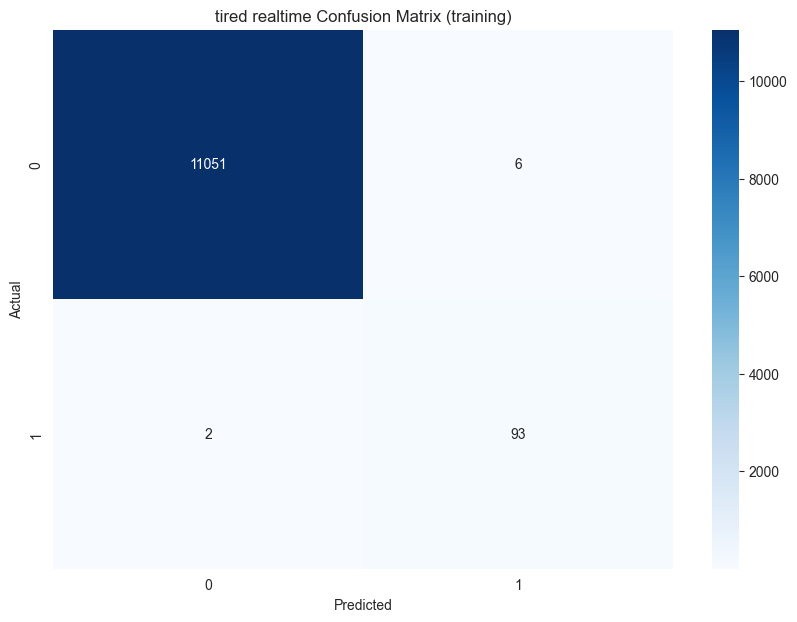

[0. 0. 0. ... 0. 0. 0.]


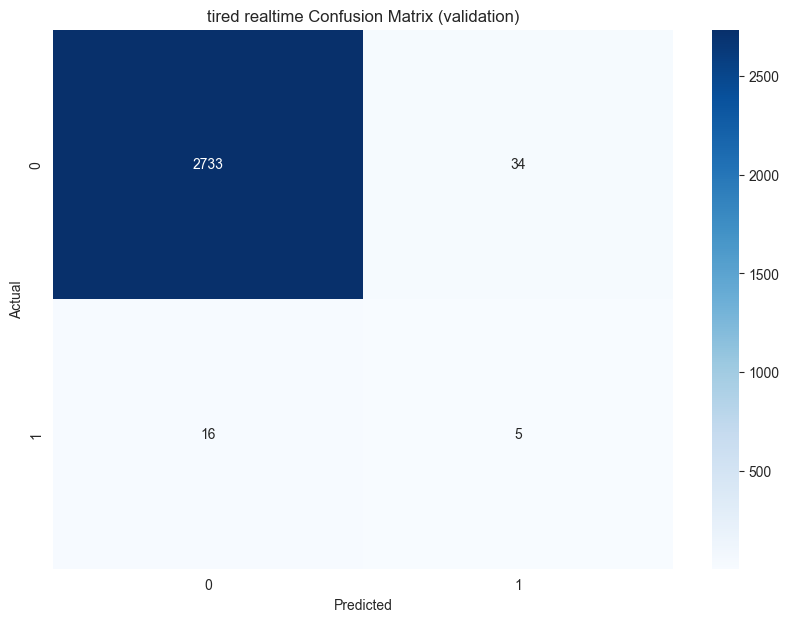

Evaluation for model:  wired realtime
wired realtime Training Set Evaluation:
wired realtime Mean Absolute Error (MAE): 0.023224533715925394
wired realtime Mean Squared Error (MSE): 0.023224533715925394
wired realtime Root Mean Squared Error (RMSE): 0.1523959767051788
wired realtime Validation Set Evaluation:
wired realtime Mean Absolute Error (MAE): 0.024748923959827834
wired realtime Mean Squared Error (MSE): 0.024748923959827834
wired realtime Root Mean Squared Error (RMSE): 0.15731790730818865


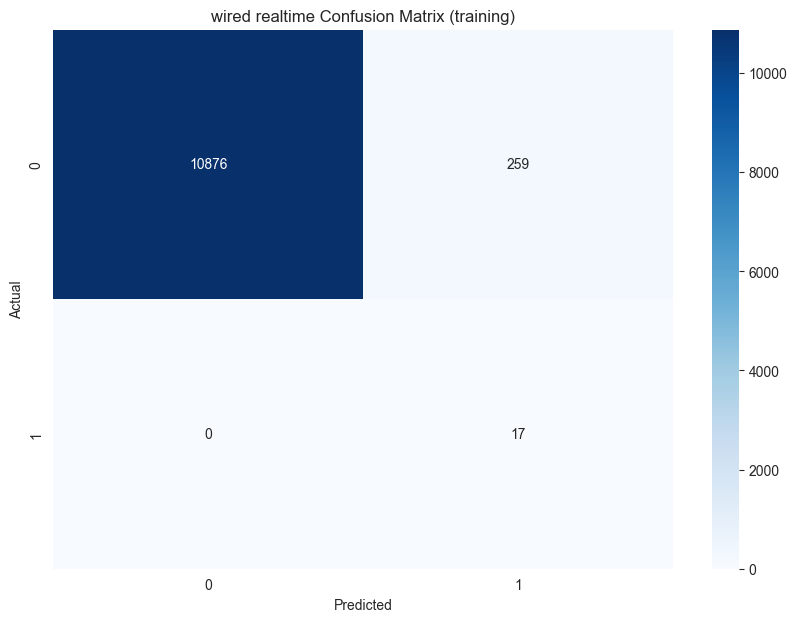

[0. 0. 0. ... 0. 1. 0.]


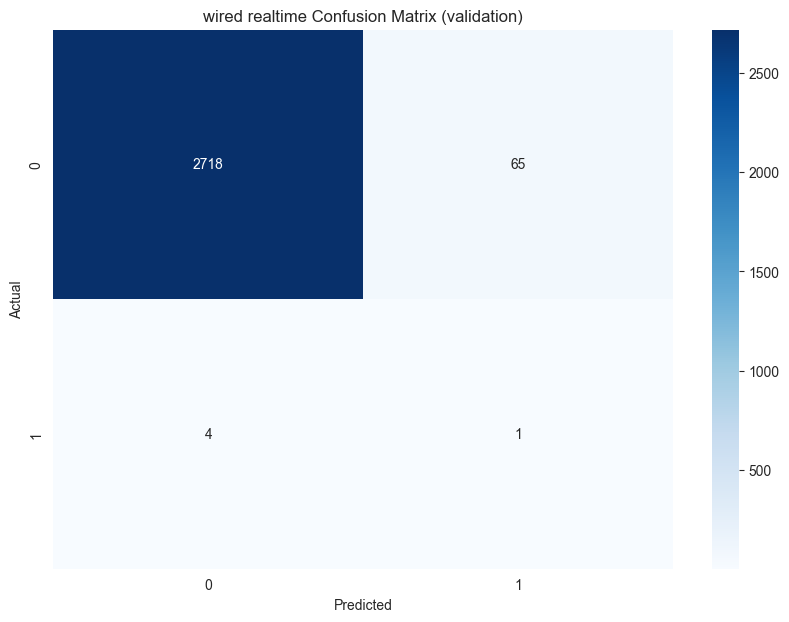

In [35]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(md: ModelAndData, model, X, y):
    # Predict the target values using the trained model
    predictions = model.predict(X)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    print(f"{md.name} Mean Absolute Error (MAE): {mae}")
    print(f"{md.name} Mean Squared Error (MSE): {mse}")
    print(f"{md.name} Root Mean Squared Error (RMSE): {rmse}")

    return mae, mse, rmse

def evaluate_classification_model(md: ModelAndData, X_train, y_train, X_val, y_val):
    model = md.model
    print("Evaluation for model: ", md.name)
    # Evaluate the model on the training set
    print(f"{md.name} Training Set Evaluation:")
    train_mae, train_mse, train_rmse = evaluate_model(md, model, X_train, y_train)
    
    # Evaluate the model on the validation set
    print(f"{md.name} Validation Set Evaluation:")
    val_mae, val_mse, val_rmse = evaluate_model(md, model, X_val, y_val)

    val_train = model.predict(X_train)

    train_results_df = pd.DataFrame({
        'Actual': y_train,
        'Predicted': val_train
    })

    cm_train = confusion_matrix(train_results_df['Actual'], train_results_df['Predicted'])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{md.name} Confusion Matrix (training)')
    plt.show()

    
    # Predict the target values using the trained model
    val_predictions = model.predict(X_val)
    print(val_predictions)
    
    # Create a DataFrame with y_val and the predictions
    val_results_df = pd.DataFrame({
        'Actual': y_val,
        'Predicted': val_predictions
    })

    cm_val = confusion_matrix(val_results_df['Actual'], val_results_df['Predicted'])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{md.name} Confusion Matrix (validation)')
    plt.show()

def evaluate_regression_model(md: ModelAndData, X_train, y_train, X_val, y_val):
    model = md.model
    print("Evaluation for model: ", md.name)

    # Evaluate the model on the training set
    print(f"{md.name} Training Set Evaluation:")
    train_predictions = model.predict_proba(X_train)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = np.sqrt(train_mse)
    print(f"MAE: {train_mae}, MSE: {train_mse}, RMSE: {train_rmse}")

    plt.figure(figsize=(10, 7))
    plt.scatter(y_train, train_predictions, alpha=0.3)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{md.name} Predictions vs Actual (training)')
    plt.show()

    # Evaluate the model on the validation set
    print(f"{md.name} Validation Set Evaluation:")
    val_predictions = model.predict_proba(X_val)
    val_mae = mean_absolute_error(y_val, val_predictions)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = np.sqrt(val_mse)
    print(f"MAE: {val_mae}, MSE: {val_mse}, RMSE: {val_rmse}")

    # Plot the predictions vs actual values for the validation set
    plt.figure(figsize=(10, 7))
    plt.scatter(y_val, val_predictions, alpha=0.3)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{md.name} Predictions vs Actual (validation)')
    plt.show()
    
for md in models_and_data:
    evaluate_classification_model(md, md.X_train, md.y_train, md.X_val, md.y_val)

## Most useful features

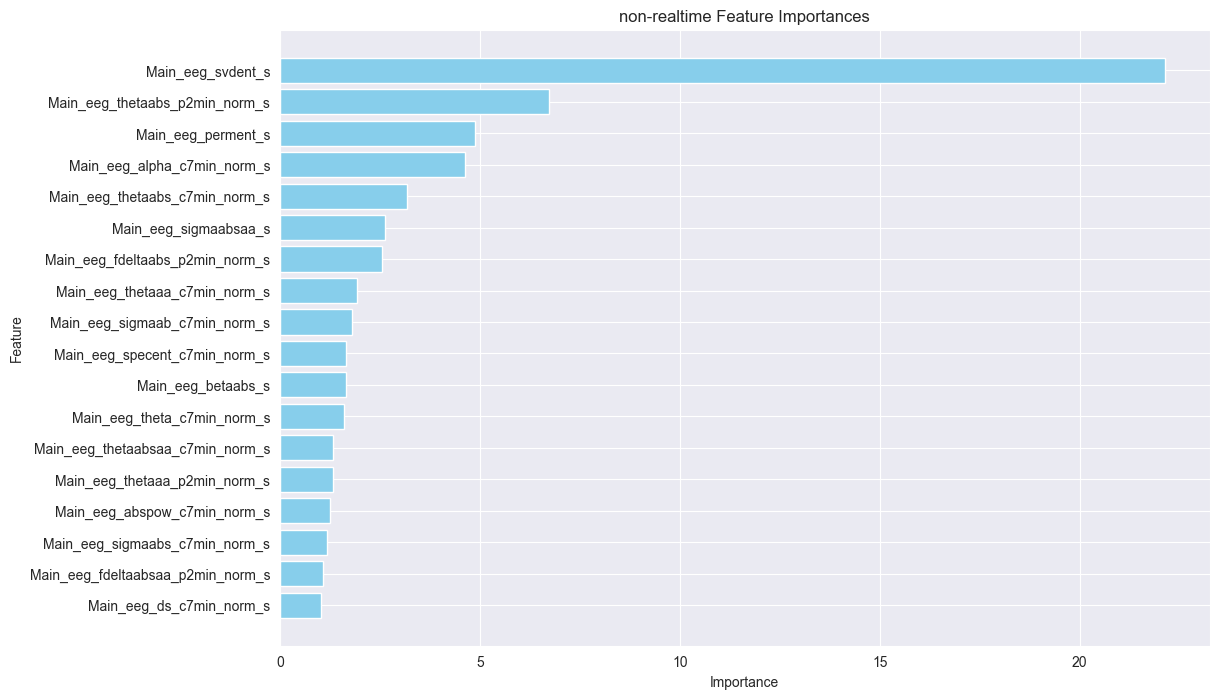

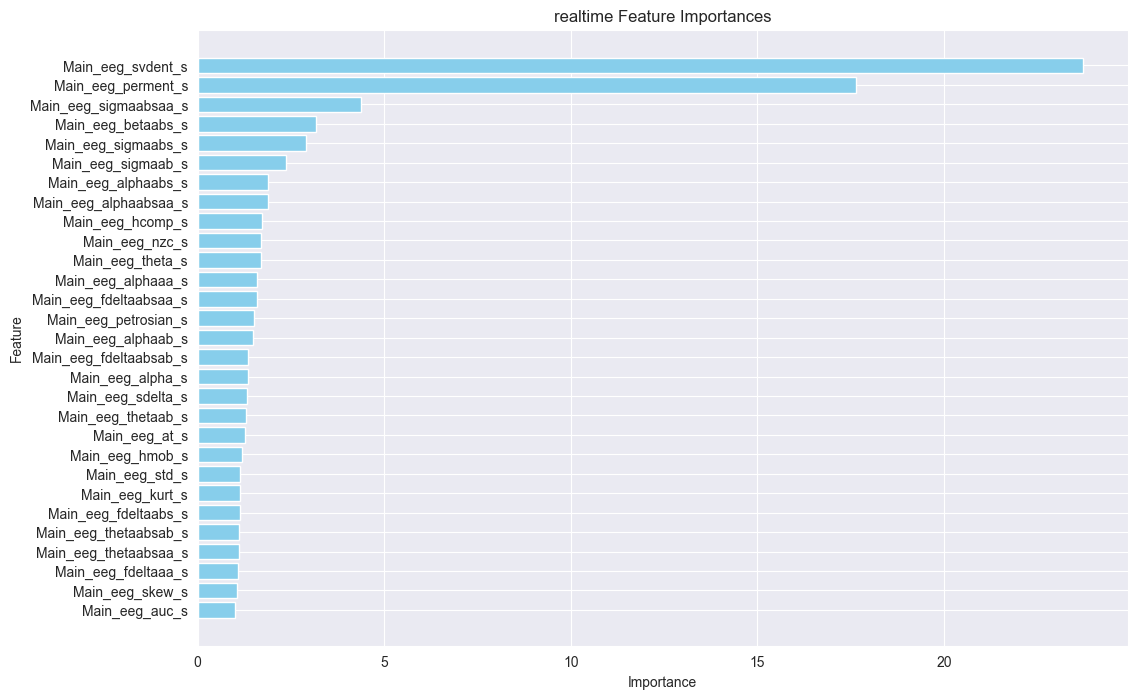

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

def importances(md: ModelAndData):
    # Get feature importances
    feature_importances = md.model.get_feature_importance()
    
    # Create a DataFrame to display the feature importances
    feature_names = md.X_train.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    importance_df = importance_df[importance_df['Importance'] > 1]
    
    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(md.name + ' Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.show()

for md in models_and_data:
    importances(md)

# Save model

In [117]:
import dotenv
dotenv.load_dotenv()

import paramiko

# Configure logging
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

def secure_copy_file(local_path, remote_path, hostname, username, password):
    # Create an SSH client
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    
    ssh.connect(hostname, username=username, password=password)

    # Open an SFTP session
    sftp = ssh.open_sftp()

    # Get the size of the file to be transferred
    file_size = os.path.getsize(local_path)

    # Define a callback function to show progress
    with tqdm(total=file_size, unit='B', unit_scale=True, desc=local_path) as pbar:
        def progress_callback(transferred, total):
            pbar.update(transferred - pbar.n)

        # Copy the file with progress callback
        sftp.put(local_path, remote_path, callback=progress_callback)

    # Close the SFTP session and SSH connection
    sftp.close()
    ssh.close()

hostname = os.getenv('SSH_HOST')
username = os.getenv('SSH_USERNAME')
password = os.getenv('SSH_PASSWORD')

for md in models_and_data:
    model_filename = f"{md.name}_catboost_model.cbm"
    md.model.save_model(model_filename)
    secure_copy_file(model_filename, '/home/graham/dev/Brainwave-Models/' + model_filename, hostname, username, password)

print("Copied all files")

non-realtime_catboost_model.cbm: 100%|██████████| 2.25M/2.25M [00:01<00:00, 1.59MB/s]
realtime_catboost_model.cbm: 100%|██████████| 2.24M/2.24M [00:00<00:00, 3.34MB/s]

Copied all files
